# Monthly hotel-room occupancy — raw exploration
We have three parallel series (high-tariff A, high-tariff B, medium-tariff).
All rates are percentages, so we convert them to proportions (`0 - 1`).



In [69]:
# %% [parameters] ------------------------------------------------------------
"""
Configuration
-------------
Nothing else in the notebook should need editing – just keep these paths / names
up-to-date if you move the file or rename columns in the source CSV.
"""
import pathlib, os

ROOT = pathlib.Path(os.getcwd()).resolve().parent  # project root
DATA_FILE = ROOT / "examples" / "data" / "hotel_room_occupancy_rate_monthly_by_cat_en.csv"

DATE_COL = "Year-Month"  # YYYYMM integer / string
VALUE_COLS = [
    "Hotel room occupancy rate of high tariff A hotels",
    "Hotel room occupancy rate  of high tariff B hotels",
    "Hotel room occupancy rate of medium tariff hotels"
]

# %% -------------------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------- load & tidy ------------------------------------------------------
df = pd.read_csv(DATA_FILE)

# strip stray whitespace in *every* column name
df.columns = df.columns.str.strip()

# YYYYMM → pandas datetime (month-start index)
df["ds"] = pd.to_datetime(df[DATE_COL].astype(str), format="%Y%m", errors="raise")

# convert % → proportion
for col in VALUE_COLS:
    df[col] = df[col] / 100.0

# ensure all values are in the open interval (0,1)
if not ((df[VALUE_COLS] > 0) & (df[VALUE_COLS] < 1)).all().all():
    raise ValueError("Some occupancy rates fall outside (0, 1) – check the raw data!")

df = df.sort_values("ds").reset_index(drop=True)
display(df.head())

,Year-Month,Hotel room occupancy rate of high tariff A hotels,Hotel room occupancy rate of high tariff B hotels,Hotel room occupancy rate of medium tariff hotels,ds
0,202002,0.14,0.26,0.41,2020-02-01
1,202003,0.12,0.30,0.47,2020-03-01
2,202004,0.12,0.32,0.50,2020-04-01
3,202005,0.14,0.35,0.54,2020-05-01
4,202006,0.19,0.42,0.62,2020-06-01


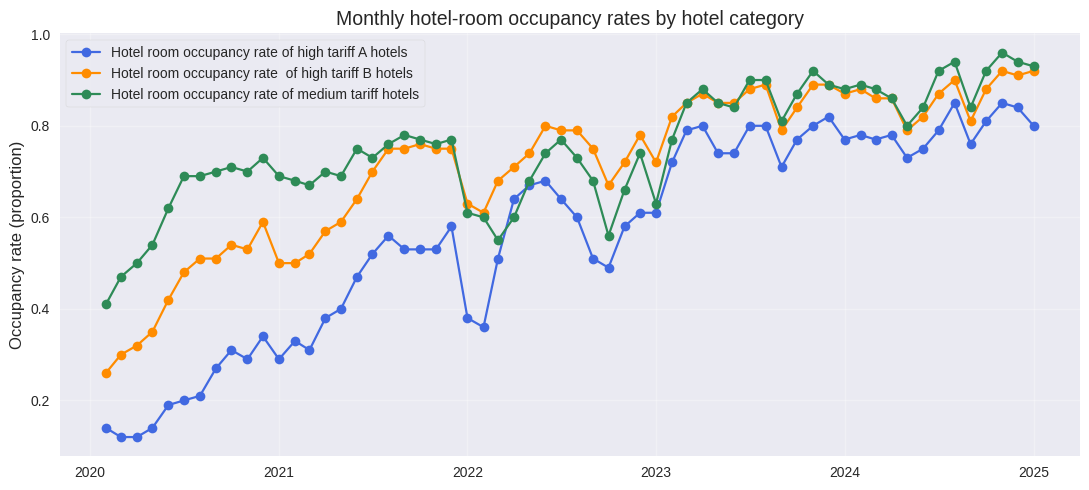

In [70]:

# --------- quick visual sanity-check ----------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(11, 5))  # Increased height for better visualization

col_colors = ["royalblue", "darkorange", "seagreen"]
for c, col in zip(col_colors, VALUE_COLS):
    ax.plot(df["ds"], df[col], marker="o", lw=1.6, label=col.strip(), color=c)

ax.set_ylabel("Occupancy rate (proportion)", fontsize=12)
ax.set_title("Monthly hotel-room occupancy rates by hotel category", fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(frameon=True, loc='best')
fig.tight_layout()

In [71]:

# %%  -------------------------------------------------------------------------
# Choose the "high-tariff A" series and set up cross-validation
# --------------------------------------------------------------------------
TARGET_COL = "Hotel room occupancy rate of high tariff A hotels"

series = (
    df[["ds", TARGET_COL]].rename(columns={TARGET_COL: "y"})
    .assign(t=np.arange(len(df), dtype=float))
)

t_all, y_all = series["t"].to_numpy(), series["y"].to_numpy()

# --- rolling-origin CV windows ---------------------------------------------
INIT_MONTHS = 24  # first 1½ years = training
CV_HORIZON = 12  # forecast 3 months ahead each fold
CV_STEP = 9  # slide by 3 months
HOLD_OUT_MO = 9  # keep last 6 months for a final test

first_test = INIT_MONTHS
fold_starts = list(range(first_test,
                         len(series) - HOLD_OUT_MO - CV_HORIZON + 1,
                         CV_STEP))
print(f"{len(series)} rows  →  {len(fold_starts)} CV folds")

60 rows  →  2 CV folds


In [72]:

# --- Optuna settings ---------------------------------------------------------
SEED = 42
TRIALS_MUR = 50
TRIALS_PROP = 30

import numpy as np

rmse = lambda a, f: np.sqrt(np.mean((a - f) ** 2))

# %%  -------------------------------------------------------------------------
# Hyper-parameter spaces, CV objective, Optuna search, hold-out fit
# --------------------------------------------------------------------------
import optuna, warnings, time
from prophet import Prophet
from murphet import fit_churn_model


In [73]:

# --- search spaces -----------------------------------------------------------
def mur_cfg(trial):
    periods, harms = [12.0], [trial.suggest_int("harm_year", 1, 4)]
    if trial.suggest_categorical("add_half", [0, 1]):
        periods.append(6.0)
        harms.append(trial.suggest_int("harm_half", 1, 3))

    return dict(
        periods=periods,
        num_harmonics=harms,
        n_changepoints=trial.suggest_int("n_cp", 2, 12),
        delta_scale=trial.suggest_float("delta_scale", 0.02, 0.8, log=True),
        gamma_scale=trial.suggest_float("gamma_scale", 1.0, 10.0),
        season_scale=trial.suggest_float("season_scale", 0.4, 2.5),
        # ρ prior is fixed inside the Stan file; beta_phi is learned there too
        likelihood="beta",
        inference="map",
        chains=2,
        iter=4000,
        warmup=0,
        seed=SEED,
    )


# --- Prophet search space ------------------------------------------------
def prop_cfg(trial):
    return dict(
        # Prophet's *built-in* yearly — we expose only its Fourier order:
        yearly_fourier=trial.suggest_int("yearly_fourier", 3, 10),

        # changepoint & seasonality priors
        cp_scale=trial.suggest_float("cp_scale", 0.01, 0.5, log=True),
        sea_scale=trial.suggest_float("sea_scale", 0.1, 10.0, log=True),
    )


# --- CV objective ------------------------------------------------------------
def cv_objective(build_cfg, is_murphet):
    def _obj(trial):
        cfg, errs = build_cfg(trial), []

        for idx in fold_starts:
            tr_end, te_end = idx, idx + CV_HORIZON
            try:
                if is_murphet:  # Murphet branch
                    m = fit_churn_model(t=t_all[:tr_end],
                                        y=y_all[:tr_end],
                                        **cfg)
                    pred = m.predict(t_all[tr_end:te_end])

                else:  # Prophet branch
                    p = Prophet(
                        changepoint_prior_scale=cfg["cp_scale"],
                        seasonality_prior_scale=cfg["sea_scale"],
                        yearly_seasonality=cfg["yearly_fourier"],  # <- one line!
                        weekly_seasonality=False,
                        daily_seasonality=False,
                    )

                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore")
                        p.fit(series.iloc[:tr_end][["ds", "y"]])

                    fut = p.make_future_dataframe(
                        CV_HORIZON, freq="MS").iloc[-CV_HORIZON:]
                    pred = p.predict(fut)["yhat"].to_numpy()

                errs.append(rmse(y_all[tr_end:te_end], pred))

            except RuntimeError:  # e.g. Stan or fitting failure
                return 1e6

        return float(np.mean(errs))

    return _obj


In [74]:

# --- search Murphet ----------------------------------------------------------
mur_study = optuna.create_study(direction="minimize",
                                sampler=optuna.samplers.TPESampler(seed=SEED))
mur_study.optimize(cv_objective(mur_cfg, True),
                   n_trials=TRIALS_MUR, show_progress_bar=True)
best_mur = mur_cfg(mur_study.best_trial)

[I 2025-04-19 23:44:00,509] A new study created in memory with name: no-name-c159f648-b630-4d35-a716-1703fe65e8ae
  0%|          | 0/50 [00:00<?, ?it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 0. Best value: 0.260059:   0%|          | 0/50 [00:00<?, ?it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:00,523] Trial 0 finished with value: 0.2600587768360767 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03556159383830237, 'gamma_scale': 2.403950683025824, 'season_scale': 0.5219755855532189}. Best is trial 0 with value: 0.2600587768360767.


23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.196607:   2%|▏         | 1/50 [00:00<00:03, 12.57it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 1. Best value: 0.196607:   4%|▍         | 2/50 [00:00<00:02, 20.67it/s]

[I 2025-04-19 23:44:00,588] Trial 1 finished with value: 0.19660652948817947 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.43117447730995384, 'gamma_scale': 2.9110519961044856, 'season_scale': 0.7818324311349114}. Best is trial 1 with value: 0.19660652948817947.
[I 2025-04-19 23:44:00,605] Trial 2 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 2, 'n_cp': 5, 'delta_scale': 0.19109751468217398, 'gamma_scale': 2.2554447458683766, 'season_scale': 1.0135037619239582}. Best is trial 1 with value: 0.19660652948817947.


23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 3. Best value: 0.175344:   8%|▊         | 4/50 [00:00<00:01, 30.64it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:00,639] Trial 3 finished with value: 0.17534410109118376 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 7, 'delta_scale': 0.17787449279672934, 'gamma_scale': 1.4180537144799796, 'season_scale': 1.6758441889930205}. Best is trial 3 with value: 0.17534410109118376.


23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:   8%|▊         | 4/50 [00:00<00:01, 30.64it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  10%|█         | 5/50 [00:00<00:01, 30.64it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:00,665] Trial 4 finished with value: 0.11052197751539508 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.06152328666462679, 'gamma_scale': 1.8790490260574548, 'season_scale': 1.8368893556755297}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:44:00,683] Trial 5 finished with value: 0.12903538220893584 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 1, 'n_cp': 12, 'delta_scale': 0.05195305024387061, 'gamma_scale': 6.962700559185838, 'season_scale': 1.054593259787763}. Best is trial 4 with value: 0.11052197751539508.


23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  12%|█▏        | 6/50 [00:00<00:01, 30.64it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  16%|█▌        | 8/50 [00:00<00:01, 33.69it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 4. Best value: 0.110522:  16%|█▌        | 8/50 [00:00<00:01, 33.69it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.11052

[I 2025-04-19 23:44:00,733] Trial 6 finished with value: 0.14866827933770116 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 12, 'delta_scale': 0.3490111324600883, 'gamma_scale': 9.455490474077703, 'season_scale': 2.2791374358980625}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:44:00,749] Trial 7 finished with value: 0.12615078326300186 and parameters: {'harm_year': 3, 'add_half': 0, 'n_cp': 4, 'delta_scale': 0.023631257130122117, 'gamma_scale': 3.927972976869379, 'season_scale': 1.2162223083479122}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:44:00,761] Trial 8 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 5, 'delta_scale': 0.1480681594456554, 'gamma_scale': 2.2683180247728636, 'season_scale': 2.0846136595834834}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:44:00,775] Trial 9 finished with value: 0.2655572734153976 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 4

23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  20%|██        | 10/50 [00:00<00:01, 33.69it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:00,811] Trial 10 finished with value: 0.11702024780765498 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.06796747685534651, 'gamma_scale': 5.106948164203384, 'season_scale': 1.5492624453518926}. Best is trial 4 with value: 0.11052197751539508.


23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  22%|██▏       | 11/50 [00:00<00:01, 33.69it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:00,843] Trial 11 finished with value: 0.11734468995600875 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.07184906174918348, 'gamma_scale': 5.161101277794808, 'season_scale': 1.5248109544745287}. Best is trial 4 with value: 0.11052197751539508.


23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 4. Best value: 0.110522:  26%|██▌       | 13/50 [00:00<00:01, 36.74it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  26%|██▌       | 13/50 [00:00<00:01, 36.74it/s]23:44:00 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:00,874] Trial 12 finished with value: 0.1107799157772198 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.08313731514398305, 'gamma_scale': 5.663432490978866, 'season_scale': 1.7713066363028485}. Best is trial 4 with value: 0.11052197751539508.
[I 2025-04-19 23:44:00,911] Trial 13 finished with value: 0.10834211048380005 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.09516981994075052, 'gamma_scale': 6.774030243803907, 'season_scale': 2.4916347166696147}. Best is trial 13 with value: 0.10834211048380005.


23:44:00 - cmdstanpy - INFO - Chain [1] done processing
23:44:00 - cmdstanpy - INFO - Chain [1] start processing
23:44:00 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  28%|██▊       | 14/50 [00:00<00:00, 36.74it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:00,992] Trial 14 finished with value: 0.1543430334401616 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 2, 'n_cp': 10, 'delta_scale': 0.11950747255621348, 'gamma_scale': 6.9706578575078435, 'season_scale': 2.4935080421174947}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  30%|███       | 15/50 [00:00<00:00, 36.74it/s]

[I 2025-04-19 23:44:01,065] Trial 15 finished with value: 0.2272024898211893 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.7883316536325532, 'gamma_scale': 7.03020539314854, 'season_scale': 2.0680539524540165}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  34%|███▍      | 17/50 [00:00<00:01, 26.54it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 13. Best value: 0.108342:  34%|███▍      | 17/50 [00:00<00:01, 26.54it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:01,096] Trial 16 finished with value: 0.16320752250817416 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 2, 'n_cp': 6, 'delta_scale': 0.040348439221669544, 'gamma_scale': 1.0299987749092168, 'season_scale': 2.368878434668648}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,127] Trial 17 finished with value: 1000000.0 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 2, 'delta_scale': 0.1042151246192406, 'gamma_scale': 3.878853162371987, 'season_scale': 2.0722208241720774}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Best trial: 13. Best value: 0.108342:  36%|███▌      | 18/50 [00:00<00:01, 26.54it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  40%|████      | 20/50 [00:00<00:01, 25.24it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  40%|████      | 20/50 [00:00<00:01, 25.24it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:01,207] Trial 18 finished with value: 1000000.0 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.2440516331924473, 'gamma_scale': 8.13720566505805, 'season_scale': 1.3980842216677203}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,230] Trial 19 finished with value: 0.3023531079856371 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.03434059205811948, 'gamma_scale': 5.985629149990219, 'season_scale': 2.2047649265143017}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,255] Trial 20 finished with value: 0.15421174390144668 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.05249002304872556, 'gamma_scale': 4.210335727372638, 'season_scale': 1.791496597748658}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  42%|████▏     | 21/50 [00:00<00:01, 25.24it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  46%|████▌     | 23/50 [00:00<00:01, 25.39it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  46%|████▌     | 23/50 [00:00<00:01, 25.39it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - 

[I 2025-04-19 23:44:01,300] Trial 21 finished with value: 0.1125495437011415 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.08879269520666615, 'gamma_scale': 6.029536508199374, 'season_scale': 1.9137931739642873}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,346] Trial 22 finished with value: 0.14363412812372078 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.08263640871375569, 'gamma_scale': 8.016463217784707, 'season_scale': 1.3326940406191727}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,379] Trial 23 finished with value: 0.12283864350797097 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.05507997245665436, 'gamma_scale': 4.805606389649002, 'season_scale': 1.6894532334070471}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  48%|████▊     | 24/50 [00:00<00:01, 25.39it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  52%|█████▏    | 26/50 [00:00<00:00, 24.40it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:01,443] Trial 24 finished with value: 0.17776262763327066 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.1216799410236142, 'gamma_scale': 5.71641343532595, 'season_scale': 2.4750135142173812}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,480] Trial 25 finished with value: 0.11142891399316776 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.09313517113565542, 'gamma_scale': 9.922818950595769, 'season_scale': 1.987801219809774}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  52%|█████▏    | 26/50 [00:01<00:00, 24.40it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  54%|█████▍    | 27/50 [00:01<00:00, 24.40it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  58%|█████▊    | 29/50 [00:01<00:00, 23.09it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:01,513] Trial 26 finished with value: 0.12222015071592696 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 7, 'delta_scale': 0.06279886643381019, 'gamma_scale': 6.462181664194474, 'season_scale': 1.7162743621180216}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,533] Trial 27 finished with value: 0.2011710172486054 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.04124697959700988, 'gamma_scale': 3.1631506992315073, 'season_scale': 1.5551453416295424}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,627] Trial 28 finished with value: 0.14959536433497655 and parameters: {'harm_year': 3, 'add_half': 1, 'harm_half': 2, 'n_cp': 11, 'delta_scale': 0.264760843433342, 'gamma_scale': 4.489752028071885, 'season_scale': 2.2853367763283554}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  58%|█████▊    | 29/50 [00:01<00:00, 23.09it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.108342:  60%|██████    | 30/50 [00:01<00:00, 23.09it/s]

[I 2025-04-19 23:44:01,648] Trial 29 finished with value: 0.27232076819840484 and parameters: {'harm_year': 2, 'add_half': 0, 'n_cp': 8, 'delta_scale': 0.03389884368979773, 'gamma_scale': 7.621761452011772, 'season_scale': 0.48221619291624374}. Best is trial 13 with value: 0.10834211048380005.
[I 2025-04-19 23:44:01,704] Trial 30 finished with value: 0.16416109396310785 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.14930969136184125, 'gamma_scale': 9.040984211153715, 'season_scale': 0.7701962138254013}. Best is trial 13 with value: 0.10834211048380005.


23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 31. Best value: 0.107681:  64%|██████▍   | 32/50 [00:01<00:00, 23.86it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  64%|██████▍   | 32/50 [00:01<00:00, 23.86it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  66%|██████▌   | 33/50 [00:01<00:00, 23.86it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 -

[I 2025-04-19 23:44:01,743] Trial 31 finished with value: 0.1076812584764048 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.09384006856476423, 'gamma_scale': 9.621347436607367, 'season_scale': 1.9384354345370407}. Best is trial 31 with value: 0.1076812584764048.
[I 2025-04-19 23:44:01,778] Trial 32 finished with value: 0.10354092192675357 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.07613987958152194, 'gamma_scale': 8.951413360526901, 'season_scale': 1.848122202387013}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:01,803] Trial 33 finished with value: 0.11028617872045238 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.046081488909892186, 'gamma_scale': 8.768496192565463, 'season_scale': 2.205972306749166}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:01,829] Trial 34 finished with value: 0.114160142234

23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  72%|███████▏  | 36/50 [00:01<00:00, 26.85it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  72%|███████▏  | 36/50 [00:01<00:00, 26.85it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:01,859] Trial 35 finished with value: 0.11645567286911365 and parameters: {'harm_year': 4, 'add_half': 1, 'harm_half': 3, 'n_cp': 7, 'delta_scale': 0.028166238671820845, 'gamma_scale': 8.74705721985174, 'season_scale': 2.36807099726969}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:01,901] Trial 36 finished with value: 0.15894146095205958 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.16458906871553067, 'gamma_scale': 9.940426101570003, 'season_scale': 1.9738651551897741}. Best is trial 32 with value: 0.10354092192675357.


23:44:01 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  74%|███████▍  | 37/50 [00:01<00:00, 26.85it/s]23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:01 - cmdstanpy - INFO - Chain [1] done processing
23:44:01 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  78%|███████▊  | 39/50 [00:01<00:00, 23.97it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  78%|███████▊  | 39/50 [00:01<00:00, 23.97it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:01,954] Trial 37 finished with value: 0.18277575954990855 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 12, 'delta_scale': 0.10793170424645106, 'gamma_scale': 9.269921327032746, 'season_scale': 2.2636501611067654}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,019] Trial 38 finished with value: 0.14393810569356358 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.20902232424792203, 'gamma_scale': 7.684844697119511, 'season_scale': 2.3569744951362845}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,048] Trial 39 finished with value: 0.12643715128757496 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 6, 'delta_scale': 0.07301961420083589, 'gamma_scale': 8.458706675504793, 'season_scale': 2.1378195449726807}. Best is trial 32 with value: 0.10354092192675357.


23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  80%|████████  | 40/50 [00:01<00:00, 23.97it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  84%|████████▍ | 42/50 [00:01<00:00, 25.41it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  84%|████████▍ | 42/50 [00:01<00:00, 25.41it/s]

[I 2025-04-19 23:44:02,079] Trial 40 finished with value: 0.17511072593972918 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 2, 'n_cp': 8, 'delta_scale': 0.049165520544013366, 'gamma_scale': 9.519198184888758, 'season_scale': 1.9141714035463147}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,119] Trial 41 finished with value: 0.11472553460114723 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 9, 'delta_scale': 0.05636075146859503, 'gamma_scale': 7.5736563534484365, 'season_scale': 1.843581504105933}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,147] Trial 42 finished with value: 0.2260053460184771 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 12, 'delta_scale': 0.06449028966897402, 'gamma_scale': 1.7664720925411328, 'season_scale': 1.607811913344602}. Best is trial 32 with value: 0.10354092192675357.


23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  86%|████████▌ | 43/50 [00:01<00:00, 25.41it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  88%|████████▊ | 44/50 [00:01<00:00, 25.41it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  92%|█████████▏| 46/50 [00:01<00:00, 26.89it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:02,192] Trial 43 finished with value: 0.16861920346119236 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 1, 'n_cp': 10, 'delta_scale': 0.140461302587808, 'gamma_scale': 9.52781895722809, 'season_scale': 2.0094565664598174}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,211] Trial 44 finished with value: 0.24091155807081813 and parameters: {'harm_year': 1, 'add_half': 0, 'n_cp': 9, 'delta_scale': 0.02751916960124445, 'gamma_scale': 2.8172019012819294, 'season_scale': 2.1927203423519708}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,252] Trial 45 finished with value: 0.14790733486477073 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 11, 'delta_scale': 0.08072354755014491, 'gamma_scale': 8.431237981429739, 'season_scale': 2.417974980653538}. Best is trial 32 with value: 0.10354092192675357.


23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  92%|█████████▏| 46/50 [00:01<00:00, 26.89it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  94%|█████████▍| 47/50 [00:01<00:00, 26.89it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:02,303] Trial 46 finished with value: 0.1092878003163624 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.10736902996258932, 'gamma_scale': 7.188436175310459, 'season_scale': 2.273319313916153}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,349] Trial 47 finished with value: 0.10468772715211482 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.10195744448017843, 'gamma_scale': 6.523446278175804, 'season_scale': 2.236088258561077}. Best is trial 32 with value: 0.10354092192675357.


23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541:  98%|█████████▊| 49/50 [00:01<00:00, 23.18it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 32. Best value: 0.103541: 100%|██████████| 50/50 [00:01<00:00, 25.34it/s]

[I 2025-04-19 23:44:02,428] Trial 48 finished with value: 0.16498171032062633 and parameters: {'harm_year': 2, 'add_half': 1, 'harm_half': 3, 'n_cp': 10, 'delta_scale': 0.10153616559701065, 'gamma_scale': 6.602740021532856, 'season_scale': 2.339720824885718}. Best is trial 32 with value: 0.10354092192675357.
[I 2025-04-19 23:44:02,481] Trial 49 finished with value: 0.14872669886206996 and parameters: {'harm_year': 1, 'add_half': 1, 'harm_half': 1, 'n_cp': 11, 'delta_scale': 0.12863593724059416, 'gamma_scale': 7.311565487876157, 'season_scale': 2.4904291183670924}. Best is trial 32 with value: 0.10354092192675357.


In [75]:

# --- search Prophet ----------------------------------------------------------
prop_study = optuna.create_study(direction="minimize",
                                 sampler=optuna.samplers.TPESampler(seed=SEED))
prop_study.optimize(cv_objective(prop_cfg, False),
                    n_trials=TRIALS_PROP, show_progress_bar=True)
best_prop = prop_cfg(prop_study.best_trial)
# --- final fit on training window ------------------------------------------
train, test = series.iloc[:-HOLD_OUT_MO], series.iloc[-HOLD_OUT_MO:]

[I 2025-04-19 23:44:02,539] A new study created in memory with name: no-name-cc44e8c2-6600-407c-bf42-7b86126d90a4
  0%|          | 0/30 [00:00<?, ?it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 0. Best value: 0.169876:   3%|▎         | 1/30 [00:00<00:06,  4.26it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215:   7%|▋         | 2/30 [00:00<00:04,  6.40it/s]23:44:02 - cmdstanpy - INFO - Chain [1] start processing
23:44:02 - cmdstanpy - INFO - Chain [1] done processing
23:44:02 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:02,774] Trial 0 finished with value: 0.16987622596579313 and parameters: {'yearly_fourier': 5, 'cp_scale': 0.4123206532618726, 'sea_scale': 2.9106359131330697}. Best is trial 0 with value: 0.16987622596579313.
[I 2025-04-19 23:44:02,875] Trial 1 finished with value: 0.12221484378732392 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.018410729205738687, 'sea_scale': 0.2051110418843398}. Best is trial 1 with value: 0.12221484378732392.


23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215:  10%|█         | 3/30 [00:00<00:04,  6.01it/s]23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215:  13%|█▎        | 4/30 [00:00<00:03,  6.92it/s]23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:03,054] Trial 2 finished with value: 0.14597482362597708 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.29621516588303487, 'sea_scale': 1.5930522616241019}. Best is trial 1 with value: 0.12221484378732392.
[I 2025-04-19 23:44:03,165] Trial 3 finished with value: 0.13680697153746085 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.01083858126934475, 'sea_scale': 8.706020878304859}. Best is trial 1 with value: 0.12221484378732392.


23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 1. Best value: 0.122215:  17%|█▋        | 5/30 [00:00<00:03,  7.31it/s]23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 5. Best value: 0.115969:  17%|█▋        | 5/30 [00:00<00:03,  7.31it/s]23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:03,288] Trial 4 finished with value: 0.12301012094423597 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.022948683681130556, 'sea_scale': 0.23102018878452935}. Best is trial 1 with value: 0.12221484378732392.
[I 2025-04-19 23:44:03,383] Trial 5 finished with value: 0.11596921232267754 and parameters: {'yearly_fourier': 4, 'cp_scale': 0.0328774741399112, 'sea_scale': 1.1207606211860568}. Best is trial 5 with value: 0.11596921232267754.


23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 5. Best value: 0.115969:  23%|██▎       | 7/30 [00:00<00:02,  7.98it/s]23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 5. Best value: 0.115969:  27%|██▋       | 8/30 [00:01<00:02,  8.19it/s]23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing


[I 2025-04-19 23:44:03,516] Trial 6 finished with value: 0.1254119056303786 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.03124565071260872, 'sea_scale': 1.6738085788752133}. Best is trial 5 with value: 0.11596921232267754.
[I 2025-04-19 23:44:03,629] Trial 7 finished with value: 0.11601172334481535 and parameters: {'yearly_fourier': 4, 'cp_scale': 0.03135775732257745, 'sea_scale': 0.5404103854647329}. Best is trial 5 with value: 0.11596921232267754.


23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 5. Best value: 0.115969:  30%|███       | 9/30 [00:01<00:03,  6.94it/s]23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
23:44:03 - cmdstanpy - INFO - Chain [1] start processing
23:44:03 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 5. Best value: 0.115969:  33%|███▎      | 10/30 [00:01<00:03,  6.58it/s]23:44:04 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:03,831] Trial 8 finished with value: 0.1359743166027902 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.21576967455896826, 'sea_scale': 0.2508115686045233}. Best is trial 5 with value: 0.11596921232267754.
[I 2025-04-19 23:44:04,003] Trial 9 finished with value: 0.12252336843739552 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.10150667045928574, 'sea_scale': 0.1238513729886093}. Best is trial 5 with value: 0.11596921232267754.


23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 10. Best value: 0.113298:  37%|███▋      | 11/30 [00:01<00:02,  6.71it/s]23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 11. Best value: 0.113234:  40%|████      | 12/30 [00:01<00:02,  7.29it/s]23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:04 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:04,145] Trial 10 finished with value: 0.11329845181878766 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.0637043254433697, 'sea_scale': 0.6199734532912116}. Best is trial 10 with value: 0.11329845181878766.
[I 2025-04-19 23:44:04,253] Trial 11 finished with value: 0.11323379702461775 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.06501502479272445, 'sea_scale': 0.6678214571929402}. Best is trial 11 with value: 0.11323379702461775.


23:44:04 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 12. Best value: 0.113128:  43%|████▎     | 13/30 [00:01<00:02,  7.47it/s]23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
23:44:04 - cmdstanpy - INFO - Chain [1] start processing
23:44:04 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.111276:  47%|████▋     | 14/30 [00:02<00:02,  6.87it/s]23:44:04 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:04,379] Trial 12 finished with value: 0.11312812145638801 and parameters: {'yearly_fourier': 3, 'cp_scale': 0.0719064967092868, 'sea_scale': 0.6036904056354223}. Best is trial 12 with value: 0.11312812145638801.
[I 2025-04-19 23:44:04,552] Trial 13 finished with value: 0.11127574990708425 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.08958498826661347, 'sea_scale': 0.527256167708933}. Best is trial 13 with value: 0.11127574990708425.


23:44:09 - cmdstanpy - INFO - Chain [1] done processing
23:44:09 - cmdstanpy - INFO - Chain [1] start processing
23:44:09 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.111276:  50%|█████     | 15/30 [00:07<00:25,  1.72s/it]23:44:10 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:10,008] Trial 14 finished with value: 0.1118476418290448 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.13223835601681144, 'sea_scale': 0.3996662608547175}. Best is trial 13 with value: 0.11127574990708425.


23:44:15 - cmdstanpy - INFO - Chain [1] done processing
23:44:15 - cmdstanpy - INFO - Chain [1] start processing
23:44:15 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.111276:  53%|█████▎    | 16/30 [00:13<00:40,  2.86s/it]23:44:15 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:15,555] Trial 15 finished with value: 0.15862674077750047 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.14862885617791483, 'sea_scale': 0.40384940836815675}. Best is trial 13 with value: 0.11127574990708425.


23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 13. Best value: 0.111276:  57%|█████▋    | 17/30 [00:18<00:47,  3.66s/it]23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 17. Best value: 0.100546:  60%|██████    | 18/30 [00:18<00:31,  2.63s/it]

[I 2025-04-19 23:44:21,106] Trial 16 finished with value: 0.17458882910269585 and parameters: {'yearly_fourier': 10, 'cp_scale': 0.14169640056443364, 'sea_scale': 3.460931541920756}. Best is trial 13 with value: 0.11127574990708425.
[I 2025-04-19 23:44:21,304] Trial 17 finished with value: 0.10054604372458374 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.10834234325942506, 'sea_scale': 0.3539728451056159}. Best is trial 17 with value: 0.10054604372458374.


23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
23:44:21 - cmdstanpy - INFO - Chain [1] start processing
23:44:21 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 17. Best value: 0.100546:  63%|██████▎   | 19/30 [00:18<00:20,  1.90s/it]23:44:21 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:21,490] Trial 18 finished with value: 0.12149825158539017 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.04955950546630037, 'sea_scale': 0.104446732715349}. Best is trial 17 with value: 0.10054604372458374.


23:44:26 - cmdstanpy - INFO - Chain [1] done processing
23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 17. Best value: 0.100546:  67%|██████▋   | 20/30 [00:24<00:28,  2.88s/it]23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing
23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 17. Best value: 0.100546:  70%|███████   | 21/30 [00:24<00:18,  2.08s/it]

[I 2025-04-19 23:44:26,669] Trial 19 finished with value: 0.17496750536613562 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.1970263374832058, 'sea_scale': 1.0417813052921943}. Best is trial 17 with value: 0.10054604372458374.
[I 2025-04-19 23:44:26,866] Trial 20 finished with value: 0.1012795912749345 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.0984600875950469, 'sea_scale': 0.32750333549080435}. Best is trial 17 with value: 0.10054604372458374.


23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:26 - cmdstanpy - INFO - Chain [1] done processing
23:44:26 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 17. Best value: 0.100546:  73%|███████▎  | 22/30 [00:24<00:12,  1.51s/it]23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 17. Best value: 0.100546:  77%|███████▋  | 23/30 [00:24<00:07,  1.12s/it]

[I 2025-04-19 23:44:27,058] Trial 21 finished with value: 0.1016046690440078 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.09130467244534733, 'sea_scale': 0.34356146407557037}. Best is trial 17 with value: 0.10054604372458374.
[I 2025-04-19 23:44:27,248] Trial 22 finished with value: 0.12244253986676311 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.047855767175242696, 'sea_scale': 0.17929275045049992}. Best is trial 17 with value: 0.10054604372458374.


23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 23. Best value: 0.0981233:  80%|████████  | 24/30 [00:24<00:05,  1.19it/s]23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:27,439] Trial 23 finished with value: 0.09812326507273858 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.10915581564683427, 'sea_scale': 0.3269464086983182}. Best is trial 23 with value: 0.09812326507273858.


23:44:27 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 23. Best value: 0.0981233:  83%|████████▎ | 25/30 [00:25<00:03,  1.50it/s]23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 23. Best value: 0.0981233:  87%|████████▋ | 26/30 [00:25<00:02,  1.93it/s]23:44:27 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:27,702] Trial 24 finished with value: 0.13893628038263636 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.21018436111848046, 'sea_scale': 0.14829931274531744}. Best is trial 23 with value: 0.09812326507273858.
[I 2025-04-19 23:44:27,874] Trial 25 finished with value: 0.103220964492447 and parameters: {'yearly_fourier': 7, 'cp_scale': 0.11098815674928854, 'sea_scale': 0.27508913015109576}. Best is trial 23 with value: 0.09812326507273858.


23:44:33 - cmdstanpy - INFO - Chain [1] done processing
23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 23. Best value: 0.0981233:  90%|█████████ | 27/30 [00:30<00:05,  1.95s/it]23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing
23:44:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:33,172] Trial 26 finished with value: 0.24635601167779134 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.28859946054566243, 'sea_scale': 0.3168074996441248}. Best is trial 23 with value: 0.09812326507273858.


23:44:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 23. Best value: 0.0981233:  93%|█████████▎| 28/30 [00:30<00:02,  1.43s/it]23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing
23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 23. Best value: 0.0981233:  97%|█████████▋| 29/30 [00:31<00:01,  1.05s/it]23:44:33 - cmdstanpy - INFO - Chain [1] start processing


[I 2025-04-19 23:44:33,401] Trial 27 finished with value: 0.1303878171680415 and parameters: {'yearly_fourier': 8, 'cp_scale': 0.16773751933158274, 'sea_scale': 0.7697617634557976}. Best is trial 23 with value: 0.09812326507273858.
[I 2025-04-19 23:44:33,563] Trial 28 finished with value: 0.12523115760542627 and parameters: {'yearly_fourier': 9, 'cp_scale': 0.050515435436115565, 'sea_scale': 0.4162669127862198}. Best is trial 23 with value: 0.09812326507273858.


23:44:33 - cmdstanpy - INFO - Chain [1] done processing
23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing
Best trial: 23. Best value: 0.0981233: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it]

[I 2025-04-19 23:44:33,760] Trial 29 finished with value: 0.13354141288049018 and parameters: {'yearly_fourier': 6, 'cp_scale': 0.29909433497448396, 'sea_scale': 0.18429788987288256}. Best is trial 23 with value: 0.09812326507273858.


In [76]:

# --- Murphet-β --------------------------------------------------------------
mur_fit = fit_churn_model(t=train["t"], y=train["y"], **best_mur)
mur_pred = mur_fit.predict(test["t"])

# --- Prophet  ---------------------------------------------------------------
prop_fit = Prophet(
    changepoint_prior_scale=best_prop["cp_scale"],
    seasonality_prior_scale=best_prop["sea_scale"],
    yearly_seasonality=best_prop["yearly_fourier"],  # tuned Fourier order
    weekly_seasonality=False,
    daily_seasonality=False,
    interval_width=0.8,
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    prop_fit.fit(train[["ds", "y"]])

future = (prop_fit
          .make_future_dataframe(HOLD_OUT_MO, freq="MS")
          .iloc[-HOLD_OUT_MO:])
prop_df = prop_fit.predict(future)
prop_pred = prop_df["yhat"].to_numpy()
prop_low = prop_df["yhat_lower"].to_numpy()
prop_upp = prop_df["yhat_upper"].to_numpy()

23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing
23:44:33 - cmdstanpy - INFO - Chain [1] start processing
23:44:33 - cmdstanpy - INFO - Chain [1] done processing


In [77]:

# --- simple numeric comparison ----------------------------------------------
print("\nHold-out RMSE")
print("Murphet-β :", rmse(test["y"], mur_pred))
print("Prophet   :", rmse(test["y"], prop_pred))


Hold-out RMSE
Murphet-β : 0.09161678082264468
Prophet   : 0.1159067219938045


Text(0.02, 0.05, 'Hold-out RMSE:\nMurphet: 0.0916\nProphet: 0.1159')

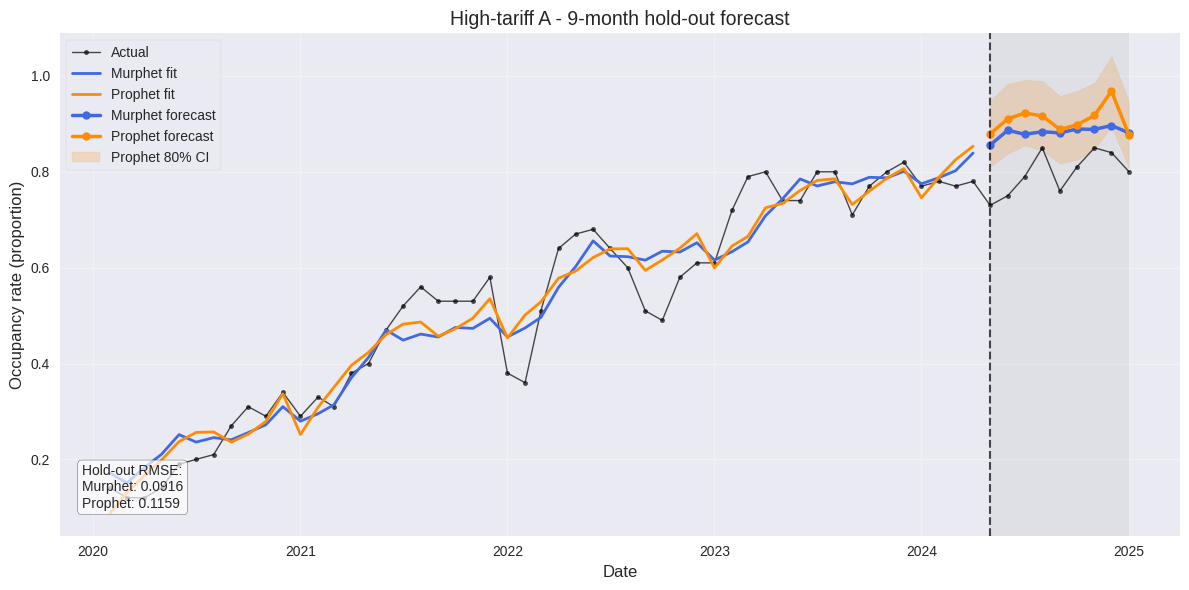

In [78]:

# --- improved visualization -------------------------------------------------
plt.style.use("seaborn-v0_8")
fig, ax = plt.subplots(figsize=(12, 6))  # Increased figure size

# Plot the full series in the background with lower opacity
ax.plot(series["ds"], series["y"], "k.-", lw=1, alpha=0.7, label="Actual")

# Plot model fits with slightly thicker lines
ax.plot(train["ds"], mur_fit.predict(train["t"]),
        color="royalblue", lw=2, label="Murphet fit")
ax.plot(train["ds"],
        prop_fit.predict(train[["ds"]])["yhat"],
        color="darkorange", lw=2, label="Prophet fit")

# Make forecast lines more visible
ax.plot(test["ds"], mur_pred, "o-", color="royalblue", markersize=6,
        lw=2.5, label="Murphet forecast")
ax.plot(test["ds"], prop_pred, "o-", color="darkorange", markersize=6,
        lw=2.5, label="Prophet forecast")

# Better confidence interval
ax.fill_between(test["ds"], prop_low, prop_upp,
                color="darkorange", alpha=0.2, label="Prophet 80% CI")

# Vertical line and improved visuals
ax.axvline(test["ds"].iloc[0], color="k", ls="--", alpha=0.7, lw=1.5)
ax.grid(True, alpha=0.3)
ax.set_title(f"High-tariff A - {HOLD_OUT_MO}-month hold-out forecast", fontsize=14)
ax.set_ylabel("Occupancy rate (proportion)", fontsize=12)
ax.set_xlabel("Date", fontsize=12)

# Better legend
ax.legend(frameon=True, fontsize=10, loc="upper left")
fig.tight_layout()

# Add shaded region for test period
ax.axvspan(test["ds"].iloc[0], test["ds"].iloc[-1], alpha=0.1, color='gray')

# Add RMSE annotation
textstr = f"Hold-out RMSE:\nMurphet: {rmse(test['y'], mur_pred):.4f}\nProphet: {rmse(test['y'], prop_pred):.4f}"
props = dict(boxstyle='round', facecolor='white', alpha=0.7)
ax.text(0.02, 0.05, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props)